<a href="https://colab.research.google.com/github/khazzan/toolwearID/blob/main/TWD_input_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the requires packages

In [1]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0
!python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral
!git clone https://github.com/khazzan/toolwearID.git

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import os
import PIL
import io
import html
import time

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)



Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (466 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


##Webcam and Helper functions
convert between data types and formats

In [6]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype = np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags = 1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format = 'png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes
def take_photo(filename = 'photo.jpg', quality = 0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # save image
  cv2.imwrite(filename, img)

  return filename

## Webcam retrival and detection

<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable


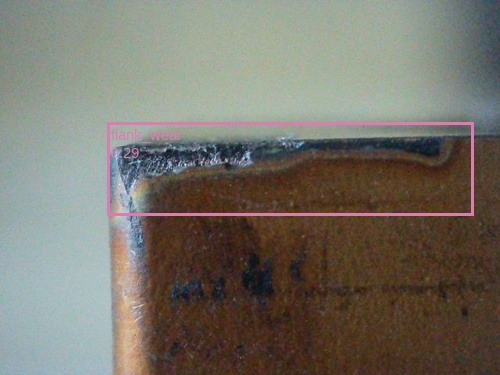

In [9]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size = (len(labels), 3), dtype = np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size = 15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill = color, font = font)

# Load the TF Lite model

LABELS_FILENAME = 'toolwearID/tf-lite_model/wear-labels.txt'
TFLITE_FILENAME = 'toolwearID/tf-lite_model/efficientdet-lite-wear.tflite'

labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

# Resize the image for input
INPUT_IMAGE = 'photo.jpg'
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold = 0.2, image_scale = scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
image